# snnTorch - Tutorial 3
### By Jason K. Eshraghian and Gregor Lenz

# Neuromorphic datasets and introduction to Tonic
Now we're going to look at how we can use datasets that were recorded with a neuromorphic camera. For that we make use of [Tonic](https://github.com/neuromorphs/tonic), which works much like PyTorch vision. We can simply install the package from pypi.

In [1]:
!pip install tonic==1.0.4 --quiet

Let's start by loading the neuromorphic version of the MNIST dataset which is called [N-MNIST](https://tonic.readthedocs.io/en/latest/datasets.html#n-mnist). We can have a look at some raw events to get a feeling what we're working with. The raw output is an NxD array of events. Every row is one event and the columns are for x and y coordinates, timestamp and polarity.

In [2]:
import tonic

dataset = tonic.datasets.NMNIST(save_to='./data', train=True)
events, target = dataset[0]
print(events)

[( 5, 23,    489, 0) (21, 13,   1790, 0) ( 1, 33,   5131, 1) ...
 (13, 14, 307497, 0) (18, 30, 308261, 1) ( 7, 15, 308966, 1)]


If we were to accumulate those events over time and plot the bins as images, it looks like this:

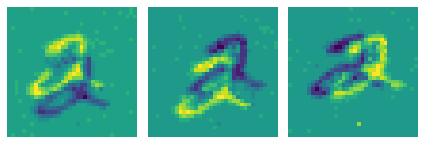

In [3]:
tonic.utils.plot_event_grid(events)

Our neural network doesn't just take as an input an array of raw events. We want to convert the raw data to a representation that is suitable, such as a tensor. We can choose a set of transforms to apply to our data before feeding it to our network. The neuromorphic camera sensor has a temporal resolution of microseconds, which when converted into a dense representation ends up in a very large tensor. That is why we bin events into a smaller number of frames using the [ToFrame transformation](https://tonic.readthedocs.io/en/latest/reference/transformations.html#frames), which reduces temporal precision but also allows us to work with it in a dense format.

In [4]:
import tonic.transforms as transforms

sensor_size = tonic.datasets.NMNIST.sensor_size
frame_transform = transforms.Compose([transforms.Denoise(filter_time=10000), 
                                      transforms.ToFrame(sensor_size=sensor_size, 
                                                         time_window=1000)
                                     ])

trainset = tonic.datasets.NMNIST(save_to='./data', transform=frame_transform, train=True)
testset = tonic.datasets.NMNIST(save_to='./data', transform=frame_transform, train=False)

The original data is stored in a format that is slow to read. To speed up dataloading, we can make use of disk caching. That means that once files are loaded from the original file, they are written to disk in an efficient format in our cache directory. Let's compare some file reading speeds to read 100 examples.

In [5]:
def load_sample_simple():
    for i in range(100):
        events, target = trainset[i]

In [6]:
%timeit -o load_sample_simple()

1.65 s ± 13.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 1.65 s ± 13.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

Let's try to decrease the time to read 100 samples by using a PyTorch DataLoader as well as disk caching.

In [7]:
from torch.utils.data import DataLoader
from tonic import CachedDataset

cached_trainset = CachedDataset(trainset, cache_path='./cache/nmnist/train')
cached_dataloader = DataLoader(cached_trainset, num_workers=4)

def load_sample_cached():
    for i, (events, target) in enumerate(iter(cached_dataloader)):
        if i > 99: break

In [8]:
%timeit -o -r 20 load_sample_cached()

543 ms ± 9.09 ms per loop (mean ± std. dev. of 20 runs, 1 loop each)


<TimeitResult : 543 ms ± 9.09 ms per loop (mean ± std. dev. of 20 runs, 1 loop each)>

Now that we've reduced our loading time to a third, we also want to use batching to make efficient use of the GPU. Because event recordings have different lengths, we are going to provide a specific collation function that takes care of how we make sure that all samples in a batch have the same dimensions. 

In [9]:
batch_size = 100
trainloader = DataLoader(cached_trainset, num_workers=4, batch_size=batch_size, collate_fn=tonic.collation.PadTensors())

In [10]:
def load_sample_batched():
    events, target = next(iter(cached_dataloader))

In [11]:
%timeit -o -r 10 load_sample_batched()

102 ms ± 1.41 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


<TimeitResult : 102 ms ± 1.41 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)>

Using disk caching and a PyTorch dataloader with multithreading and batching support we have reduced loading times to less than a tenth per sample in comparison to naively iterating over the dataset!

# Training our network using frames created from events

Now let's actually train a network on the N-MNIST classification task. We start by defining our caching wrappers and dataloaders. While doing that, we're also going to apply some augmentations to the training data. The samples we receive from the cached dataset are frames, so we can make use of PyTorch Vision to apply whatever random transform we would like.

In [ ]:
import torch
import torchvision

transform = tonic.transforms.Compose([torch.from_numpy,
                                      torchvision.transforms.RandomRotation([-10,10])])

cached_trainset = CachedDataset(trainset, transform=transform, cache_path='./cache/nmnist/train')

# no augmentations for the testset
cached_testset = CachedDataset(testset, cache_path='./cache/nmnist/test')

batch_size = 128
trainloader = DataLoader(cached_trainset, num_workers=4, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(), shuffle=True)
testloader = DataLoader(cached_testset, num_workers=4, batch_size=batch_size, collate_fn=tonic.collation.PadTensors())

A mini-batch now has the dimensions (time steps, batch size, channels, height, width). The number of time steps will be the one of the longest recording in the mini-batch, as all other samples have been padded with zeros.

In [ ]:
event_tensor, target = next(iter(trainloader))
print(event_tensor.shape)

## Defining our network

## Training

In [14]:
for i, (event_tensors, targets) in enumerate(iter(trainloader)):
    # train here
    break